In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
K_real.shape

(2016, 75)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

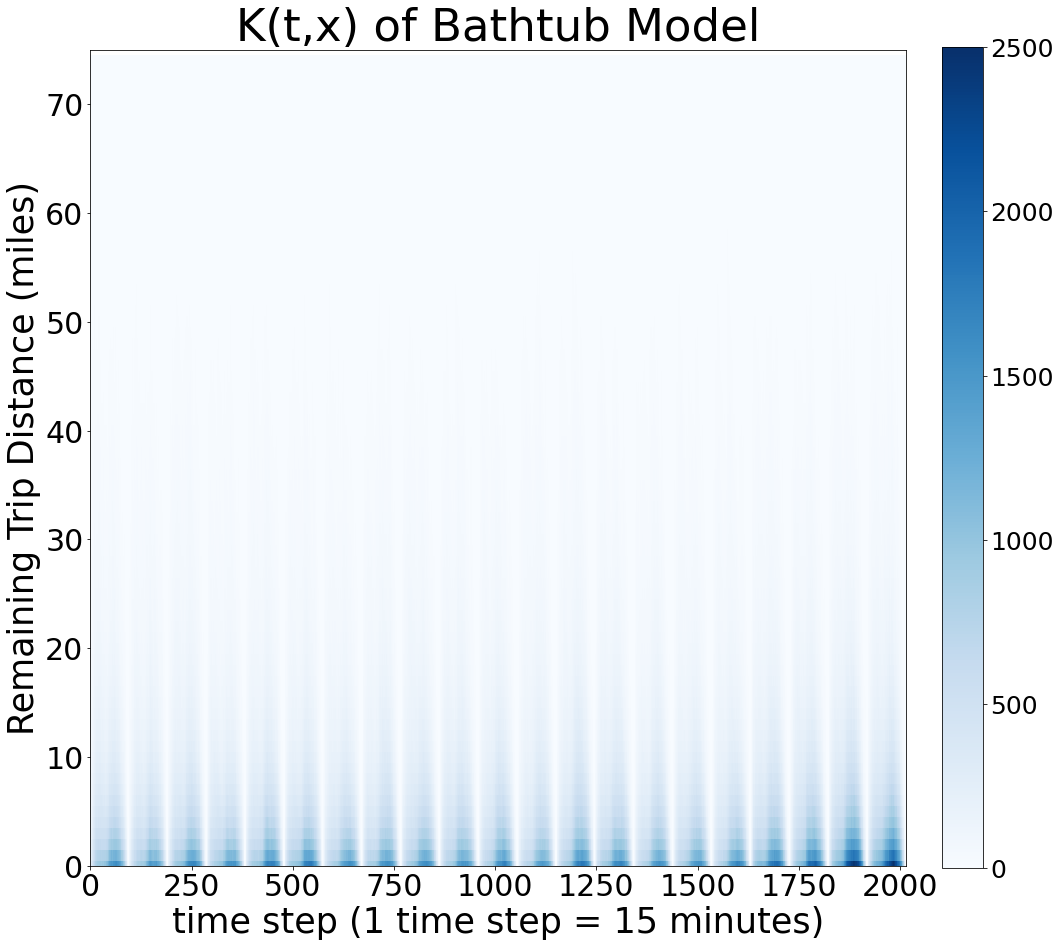

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  151200
N_u =  30240
N_f =  60480


In [ ]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [7]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [8]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T.flatten()[:,None],T.T.flatten()[:,None]))
    all_u_train = usol.flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [9]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [10]:
X_u_train.shape

(30240, 2)

In [11]:
X_u_test.shape

(120960, 2)

In [12]:
X_u_train

array([[0.24324324, 0.20545906],
       [0.81081081, 0.48883375],
       [0.66216216, 0.36674938],
       ...,
       [0.36486486, 0.48238213],
       [0.36486486, 0.60248139],
       [0.37837838, 0.24764268]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [13]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [14]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
#                                             'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 3000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.003091281837939427 0.0054686214222420962 0.00071394225363675783 0.7805539572855138
0.0030464008636118681 0.0054535282209877932 0.00063927350623594259 0.7799342256760305
0.003017168918111747 0.005449226670373869 0.00058511116584962508 0.7800712875795346
0.002982521822321756 0.0054139608670370973 0.00055108277760641475 0.7779772362989044
0.0029001892626635091 0.0053013916947040095 0.00049898683062300894 0.7707822215240997
0.0028224099616141261 0.0052053273197018137 0.00043949260352643861 0.7644718284579667
0.0027726688075291597 0.0051714075955827023 0.00037393001947561737 0.7619625378404208
0.0027472822498472377 0.005161353710440914 0.000333210789253561 0.7609955630462157
0.0027328741936957011 0.0051571156226198813 0.00030863276477152056 0.7604026627379503
0.002716146224410524 0.005155157650324137 0.00027713479849691145 0.7599577094593123
0.002707471002612781 0.0051518639396496719 0.00026307806557588986 0.7596814354869387
0.0027014998548421645 0.0051507784468466768 0.000252221262837652

0.0017380354118684295 0.0029796283260974605 0.00049644249763939848 0.5784296671481719
0.0017379259935851221 0.0029785927919855591 0.00049725919518468537 0.578349543116819
0.0017377457367098166 0.0029789846432671956 0.00049650683015243732 0.5783827966307874
0.0017373559653638335 0.0029804763659476321 0.0004942355647800349 0.5785074410190646
0.0017370694274709407 0.0029811976344947897 0.00049294122044709167 0.5785776823554359
0.0017369146754992093 0.0029786560272459747 0.00049517332375244381 0.5783430864195759
0.0017368038389615026 0.0029784404238999774 0.00049516725402302779 0.5783047684968147
0.0017367214292124324 0.0029809294849925177 0.0004925133734323472 0.5785240688173983
0.0017366745819951902 0.0029805290008532181 0.00049282016313716235 0.5784896501319552
0.0017366500973771879 0.0029800587081524432 0.00049324148660193263 0.5784454045425778
0.0017366166971271193 0.0029798959209659738 0.00049333747328826464 0.5784290757072514
0.0017365826119633838 0.0029799496104930523 0.00049321561

0.0017292473545876459 0.0029602086096123742 0.0004982860995629175 0.5764752650988719
0.0017291755772073734 0.0029570500432549635 0.000501301111159783 0.5761741430629181
0.0017291125994979065 0.0029543142366275843 0.00050391096236822883 0.5759046341452538
0.0017290777297318857 0.0029528674665216044 0.000505287992942167 0.5757763671577119
0.0017290419115049442 0.0029546965171613621 0.0005033873058485263 0.5759233680205064
0.0017289801002863148 0.0029514139447932432 0.00050654625577938647 0.5756296080639398
0.0017289447336676417 0.0029522815749549775 0.000505607892380306 0.575707909259404
0.0017289080820746606 0.0029531989115176224 0.00050461725263169872 0.5757758944561271
0.0017288678097860275 0.0029548848436998635 0.00050285077587219147 0.5759362140948392
0.0017288434223903248 0.00295441223460908 0.0005032746101715698 0.5758966861062326
0.0017288272273903826 0.0029553648517517597 0.00050228960302900548 0.5759812542179187
0.001728781482212168 0.0029568819024702302 0.00050068106195410569 

0.0017236457523064741 0.0029463447978082926 0.00050094670680465544 0.5749597757747914
0.0017236404761951107 0.0029457199701910237 0.0005015609821991978 0.5749027852003571
0.0017236239538737609 0.002944726637826408 0.00050252126992111391 0.5748133606758534
0.0017235902438170899 0.0029441923317107565 0.00050298815592342337 0.5747699425003815
0.0017235461848712397 0.0029449097197449593 0.00050218264999752 0.5748469769310404
0.0017234992247666437 0.0029460345479124283 0.00050096390162085935 0.5749548495269631
0.0017233902745415587 0.0029491177097871052 0.00049766283929601231 0.5752351332964717
0.0017233064208070558 0.0029482986104261933 0.00049831423118791855 0.575146552173093
0.0017232167656497544 0.0029507471611299693 0.0004956863701695394 0.57536361159659
0.0017230858265231523 0.0029471616548760208 0.00049900999817028375 0.5749986909179877
0.0017230751135377453 0.002949653361570046 0.00049649686550544479 0.5752637448838366
0.0017230121219311337 0.00294564462554151 0.00050037961832075735

0.0017191970377576134 0.00294242947326948 0.00049596460224574676 0.5743750614142603
0.0017191903443352381 0.0029422784318062088 0.000496102256864267 0.5743521873380837
0.00171918533189202 0.0029421059808337753 0.00049626468295026454 0.5743399078040757
0.0017191747073639944 0.0029414842100534706 0.0004968652046745182 0.5742819922419284
0.0017191616099205224 0.0029415352889654947 0.00049678793087555031 0.574293931052006
0.0017191523499780908 0.0029419520252414542 0.00049635267471472737 0.5743315142158516
0.0017191468933059873 0.0029421475711999168 0.000496146215412058 0.5743494265920724
0.0017191446144512877 0.0029423587366842171 0.00049593049221835852 0.5743659680642832
0.0017191417101376305 0.0029425013830192094 0.00049578203725605171 0.5743792000957775
0.0017191348673774747 0.0029424712587450435 0.000495798476009906 0.574377182783918
0.0017191274359943274 0.0029426555568396978 0.000495599315148957 0.5743923080616402
0.0017191135110067154 0.0029428155624726077 0.00049541145954082333 0.

0.0017182149828421781 0.0029421937179382944 0.00049423624774606184 0.5743706625557613
0.0017182094721235727 0.002942129340629587 0.00049428960361755847 0.5743605837736251
0.0017181998240980165 0.0029429742465675026 0.00049342540162853037 0.5744396020416505
0.0017181889342975717 0.0029430936250113221 0.00049328424358382127 0.5744436418380641
0.0017181848877769427 0.002943128216638976 0.00049324155891490931 0.5744476236626298
0.0017181788455288406 0.0029434703715496735 0.00049288731950800774 0.5744756839215298
0.0017181742198708375 0.0029429915422385707 0.00049335689750310409 0.574432031211799
0.0017181660955053173 0.0029430838003710502 0.00049324839063958465 0.574442864243796
0.0017181586592014471 0.0029431215045986644 0.00049319581380422993 0.5744506508094607
0.0017181548799184918 0.0029435014863774915 0.000492808273459492 0.5744825520857215
0.001718152634990369 0.0029438786084460076 0.00049242666153473066 0.5745178234391616
0.0017181520567243523 0.0029436399562083621 0.000492664157240

0.0017170375012835648 0.0029377921825511615 0.00049628282001596823 0.574086995039307
0.0017170267306657616 0.0029375948174171357 0.0004964586439143876 0.5740812860951503
0.0017170225292689493 0.0029382481301568337 0.00049579692838106512 0.5741413856029063
0.0017170170343789003 0.0029382451166112267 0.00049578895214657387 0.5741417338352474
0.0017169998493618414 0.0029373851893834861 0.00049661450934019658 0.5740646132766992
0.0017169893324571262 0.0029389683234812003 0.00049501034143305212 0.5742124518253162
0.0017169637865064647 0.0029386706563952693 0.00049525691661766015 0.5741795757105852
0.001716931162030531 0.0029381012934512592 0.00049576103060980294 0.5741198233211885
0.0017169002033506622 0.0029364982743656618 0.00049730213233566275 0.5739621038631219
0.0017168925135829451 0.0029383600118763273 0.00049542501528956309 0.574123471674668
0.0017168764059444798 0.0029389966656316619 0.00049475614625729789 0.5741902713976379
0.0017168579815674829 0.0029382837294790035 0.000495432233

0.0017153588100288937 0.0029327568320406698 0.00049796078801711769 0.5738126354649017
0.00171535705768677 0.0029328043224600203 0.00049790979291351961 0.5738196442533542
0.0017153514235910986 0.0029313483176587264 0.00049935452952347067 0.5736907502689722
0.0017153407088508267 0.0029316031901117263 0.00049907822758992685 0.5737162580154896
0.0017153010293000323 0.0029321655256497156 0.00049843653295034878 0.5737735256418093
0.001715285659318021 0.00293299389896725 0.00049757741966879182 0.5738488712534049
0.00171526953695525 0.0029301070551430628 0.00050043201876743691 0.5735944093981152
0.0017152473465179934 0.0029306488651472226 0.000499845827888764 0.5736422701057146
0.0017152262567069847 0.0029314913760897085 0.00049896113732426093 0.5737323007474611
0.0017151768392210675 0.0029308995417053614 0.00049945413673677368 0.573716830623302
0.0017151659090326921 0.0029320509370489162 0.000498280881016468 0.573802221498788
0.0017151261793935881 0.0029343203194716052 0.00049593203931557112 

0.0017125825928994975 0.0029272244605473316 0.0004979407252516633 0.5732829298547054
0.0017125327522109312 0.0029314754898799242 0.00049359001454193853 0.5736665511869556
0.0017125032272421038 0.0029300480413818695 0.00049495841310233824 0.5735381323349579
0.0017124706657251102 0.002926592166952961 0.00049834916449725949 0.5732092652526405
0.0017124480144448378 0.0029254226835266697 0.00049947334536300562 0.5731266108280492
0.0017124336597348262 0.0029273813343604995 0.00049748598510915276 0.5732962487526256
0.0017124269348186027 0.0029279811855586944 0.00049687268407851116 0.5733542394159686
0.0017124163423875849 0.002926085711339863 0.00049874697343530664 0.5731813264133866
0.0017124094307124184 0.0029261064312150666 0.00049871243020977016 0.5731904980002036
0.0017124003813415733 0.0029255541972231266 0.00049924656546002013 0.5731374569651208
0.0017123915167722042 0.0029253355457597077 0.000499447487784701 0.5731151155709515
0.0017123875874338853 0.0029253273515512379 0.0004994478233

0.0017119205595551058 0.0029230542417434434 0.00050078687736676824 0.5728991937002421
0.0017119084314712722 0.0029230279816422006 0.00050078888130034363 0.5728987206112497
0.0017119033828384258 0.0029218108866475674 0.00050199587902928391 0.572793624662413
0.0017118883044046115 0.0029228376120033848 0.00050093899680583832 0.5728761155860236
0.0017118725935412133 0.0029233388520651469 0.00050040633501727966 0.5729328942712206
0.0017118642948071472 0.002922765890523009 0.00050096269909128549 0.5728864123272045
0.0017118563832097446 0.0029224404877230374 0.00050127227869645207 0.5728612635382273
0.0017118506116668266 0.0029233096350589961 0.00050039158827465684 0.5729473115440615
0.0017118216590788031 0.0029226803388848139 0.0005009629792727925 0.5728843371061764
0.0017118206911694608 0.00292424160682948 0.00049939977550944158 0.573013804240007
0.00171180787474144 0.0029232447965136387 0.000500370952969241 0.5729304586784341
0.0017117951008179247 0.0029225220098517348 0.000501068191784114

In [15]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 2320.99
      fun: 0.0017115587707610602
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.15906896e-07,  1.09389426e-07,  7.35075305e-08, ...,
        7.88775071e-07, -1.29789377e-07,  3.85840849e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1109
      nit: 943
     njev: 1109
   status: 0
  success: True
        x: array([ 0.03425816, -0.57174954,  0.37551313, ..., -0.17708311,
       -0.3337601 ,  0.22356373])
Test Error: 0.57293
--------------------------------------------------
MAE =  0.019880085421595677
MSE =  0.002825785808656276
RMSE =  0.05315812081569735
L2 relative error = 0.572927333494414
--------------------------------------------------


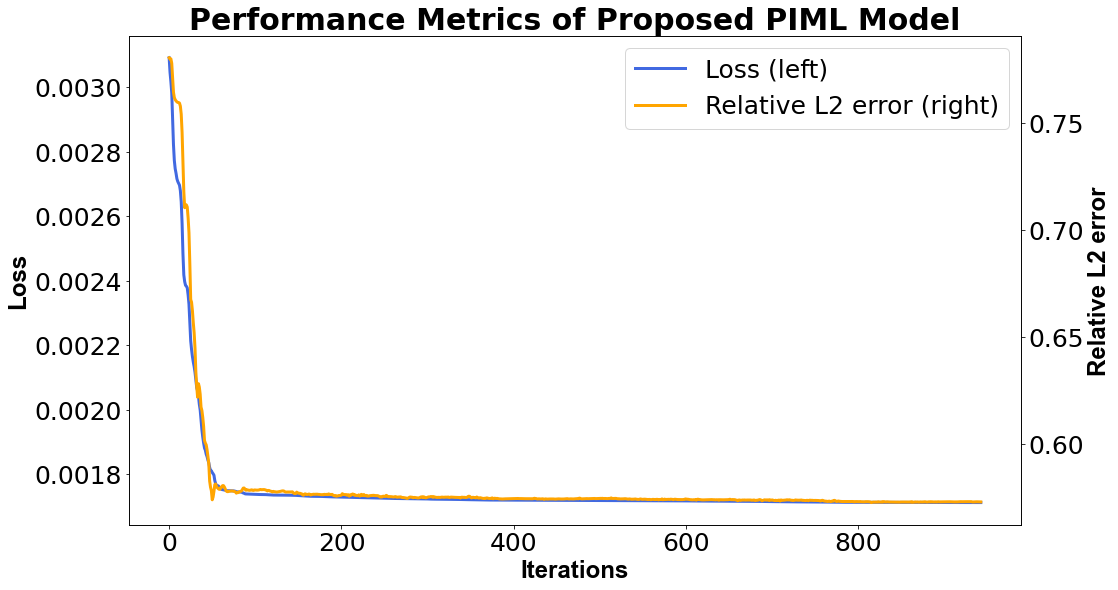

In [16]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)
fig.savefig('Loss_PIML_distone.svg', dpi=300)
fig.savefig('Loss_PIML_distone.pdf', dpi=300)
fig.savefig('Loss_PIML_distone.png', dpi=300)

# 전체 그리드 비교

In [17]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.01995002858570217
MSE =  0.0028452488474859958
RMSE =  0.05334087407875874
L2 relative error = 0.5168611699101007
--------------------------------------------------


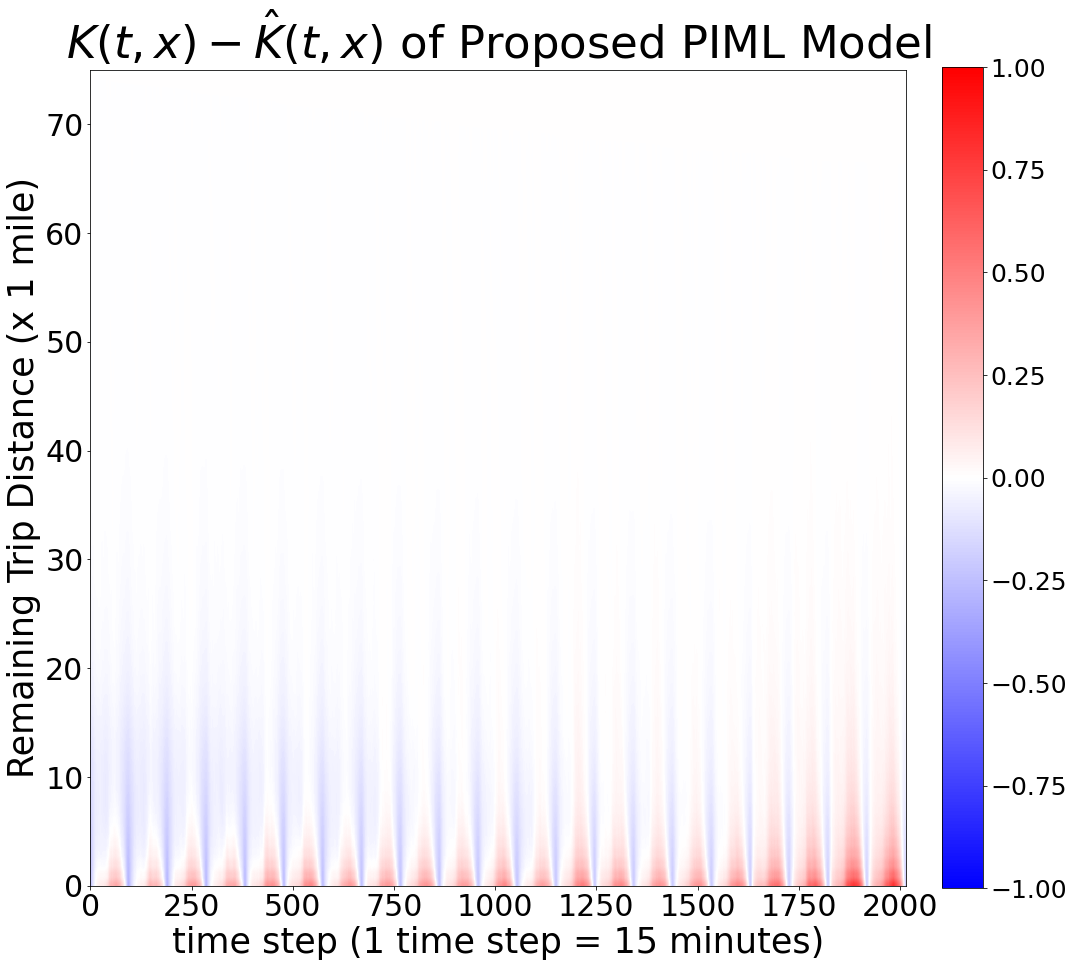

In [18]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)
fig.savefig('Difference_K_PIML_distone.svg', dpi=300)
fig.savefig('Difference_K_PIML_distone.pdf', dpi=300)
fig.savefig('Difference_K_PIML_distone.png', dpi=300)

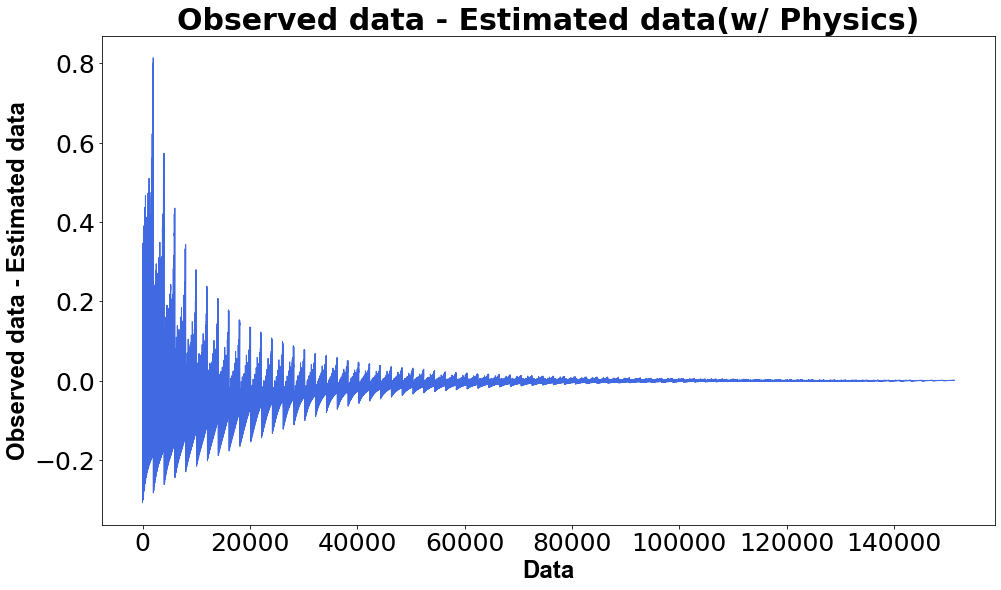

In [19]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)